# Kernel Implementation of Speller

* One step version of "Reconvolution", i.e. there is no first step to learn the temporal dynamics (for each channel) via a MSE-based decomposition of a training signal
* Constructs the short and long pulse structure matrices M_s and M_l from the binary Gold codes to form the 'Y' input of CCA, while the 'X' is filtered EEGs channels aligned in time with the Gold codes
* EEG signals decimated to 240 Hz, screen refresh rate at 60 Hz which means each stimulation sequence (consisting of 126 bits) gives a total flickering duration of 126/60 = 2.1 s
* HP (Butterworth?) filter with stop and pass at 2 nd 5 Hz resp. and then z-score all channels via the mean and standard deviation calculated from the first 20 seconds of the signal 
* "We know that the brain response to a visual flash is fast and lasts less than 250 ms", so this gives us the number of delays to use in the structure matrices = 0.25 s x 240 Hz = 60 delays. This is the number of columns of each M
* The number of rows of each M is (2.1 + 0.25)s * 240 Hz = 564. (The last 0.25 corresponds to the maximum possible length of the brain response to the last flash in the stimulation sequence)
* Prediction occurs by highest Pearson correlation between the projected brain signal and each of the 36 projected Gold codes
* Prediction confidence comes from the difference between leave-one-out z-score of the highest and second highest correlations 

## TODO

* Check that the Thielen dataset we downloaded contains the set "V" of Gold codes - Kernel state this is what they use
* Work out how to time-align the EEG signals and gold codes
* Check if z-scoring is per channel or if it averages over channels

## Plan

* Decompose each Gold code into its short and long flashes. Could see if this is what stim2event does...
* Form each M matrix:
 - Get the first column by stretching to same number of samples as brain activity, i.e. codelength (126 bits) * brain sample frequency
 - Get the other columns by building Toeplitz matrix
 - Concatenate the two M matrices
* For the first trial, we train only (no prediction possible yet), so we do CCA between the EEG channels (X) and the structure matrices for the *true* stimulation sequence (i.e. the true object). For the 2nd trial, we first predict based on the learned CCA model weights so far, by scoring the Pearson correlations of the X projection with each (of 36) possible projected stim sequences. Then we update training by concatenating the new X along the 0th dimension, and the same for the new Y. And repeat...

## Weirdness

* The EEG data (after being preprocessed and resampled in the MATLAB script), comes in a 1513 samples per trial (per channel) which is one more than the expected 4.2 seconds * 360 Hz! The codes (or the derived stimulus events) are upsampled and then repeated to match the length of the EEG trial. This ought to mean a repetition of 4 since each trial consisted of 4 repetitions of the Gold code, but instead we have to multiply by an awkward 4.0026 (in practice this means repeating the first bit of the sequence on the end of the 4th repetition).
 - I've dealt with this here by chopping off either the first or last sample (configurable in the loader function) of each trial in each channel. Not sure how sensible this is.
 - Also try (i) extract the stim events with stim2events, (ii) upsample (by 3), (iii) loop by ceil(1513/378) (iv) keep the sequence up to 1513. This is more in line with the example MATLAB script. THIS IS NOW IMPLEMENTED, AND IS THE DEFAULT APPROACH
 
 
## TODO
* Play with the order of code upsampling, event extraction and looping to see if we can smooth out the learned temporal dynamics / improve accuracies
* Kernel did z-scoring of all channels using the mu and sigma from the first 20 seconds of data - I haven't done anything like this yet

In [3]:
import numpy as np
from mindaffectBCI.decoder.analyse_datasets import debug_test_dataset, analyse_dataset, analyse_datasets
from mindaffectBCI.decoder.offline.load_mindaffectBCI  import load_mindaffectBCI
from mindaffectBCI.decoder.stim2event import stim2event
from scipy.io import loadmat
import scipy.linalg as linalg
from sklearn.cross_decomposition import CCA as CCA
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 8] # bigger default figures

In [4]:
pwd

'/Users/rorybeard/Comind/pymindaffectBCI'

In [5]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [6]:
def load_thielen_train(data_mat_path, hack_type=None):
    """
    Carries out no additional preprocessing (e.g. filtering, resampling) - assumes this has
    already been performed
    """
    d = loadmat(data_mat_path)
    ofs = d['resamplefs'][0][0]  # sample rate after downsampling
    X = d['data']
    if X.shape[1] != 1513:
        raise Exception("Trial length is not 1513 samples")
    else:
        if hack_type:
            # temporary hack to reduce the number of EEG samples to the expected number of 4.2 seconds * 360 Hz = 1512
            if hack_type == 'last':
                X = X[:, :-1, :]
            elif hack_type == 'first':
                X = X[:, 1:, :]
                raise Exception("Unrecognised hack type!")
            
    X = X.astype("float32")  # (n_chan, n_samp, n_trial) raw eeg
    X = np.moveaxis(X, (0, 1, 2), (2, 1, 0))  # (n_trial, n_samp, n_chan)
    X = np.ascontiguousarray(X)  # ensure memory-efficient layout
    
    labels = d['labels']  # (n_trial, 1)  # NB n_trial = nY in this Thielen data
    labels = labels.astype('uint8').ravel()
    
    codes = d['codes']  # (code_length, nY) where nY is number of codes (i.e. objects)
    codes = codes.astype('bool')
    codes_orig = codes
    
    # convert labels + code into Y + samp-times,  where 1st row is always the true label
    # loop codes up to X size (NB this assumes n_trial = nY, which it does for this data)
    codes = codes[np.mod(np.arange(0, X.shape[1]), codes.shape[0]), :]  # (n_samp, nY)
    Y = np.zeros((len(labels), X.shape[1], codes.shape[1]+1), dtype=bool) # (n_trial, n_samp, nY+1)
    for ti, lab in enumerate(labels):
        Y[ti, :, 0] = codes[:, lab - 1]  # copy in true label
        Y[ti, :, 1:] = codes # copy in other outputs
        
    # make coords array fro the meta-info about the dimensions of X
    coords = [None] * X.ndim
    coords[0] = {'name': 'trial'}
    coords[1] = {'name': 'time',
                 'unit': 'ms',
                 'coords': np.arange(X.shape[1]) * 1000 / ofs,
                 'fs': ofs}
    coords[2] = {'name': 'channel',
                 'coords': None}
    
    return (X, Y, coords, codes_orig, labels)

In [102]:
def build_structure_mats_from_codes(codes, f_eeg, f_pres, resp_len, eeg_trial_len, persist_event=False):
    """
    NB no additional alignment performed here...
    Upsample the codes by f_eeg/f_stim, extract the short and long onset sequences, and then return *concatenated*
    Ms and Ml for each of the Gold codes as a (code_len*rate_ratio, f_eeg*response_len*2, 36) array of floats
    NB Since stim2event expects events either "010" or "0110", we need to apply this function to the original codes, 
    *before* they are upsampled. We can then upsample the extracted event sequences afterwards
    Args:
        codes: (code_len, n_codes) binary ndarray [126, 36]
        f_eeg: integer [360], the sample rate of the EEG acquisition
        f_pres: integer [120], the sample rate of the visual presentation of the simulus
        response_len: duration in seconds of the transient V1 response to a single flash, as discernable by EEG
    """
    rate_ratio = f_eeg / f_pres
    n_resp_samp = int(f_eeg * resp_len)
    
    
    evts = stim2event(codes, axis=0, evtypes=['short', 'long'])  # (code_len, n_codes, n_evt_types) [126, 36, 2]
    # NB short event sequence is evts[:,:,0], long event sequence is evts[:,:,1]
    
    # depending on method, either upsample the event sequences (so e.g. the 1 bit for the presence of an event will
    # persist for rate_ratio EEG samples) or pad with zeros so that we only have a 1 bit for the onset of the event
    if persist_event:
        evts_up = np.repeat(evts, repeats=rate_ratio, axis=0)  # (code_len*rate_ratio, n_codes, n_evt_types) [378, 36, 2]
    else:
        evts_up = np.zeros((evts.shape[0]*int(rate_ratio), evts.shape[1], evts.shape[2]))

        for ii, i in enumerate(range(0, evts_up.shape[0], int(rate_ratio))):
            evts_up[i, :,:] = evts[ii, :,:]
            
    
    evts_up = evts_up.astype(int)
    
    # upsample
    struct_mats = np.zeros((evts_up.shape[0], n_resp_samp, evts_up.shape[1], evts_up.shape[2]))
    for i_evt_type in range(struct_mats.shape[3]):
        for i_code in range(struct_mats.shape[2]):
            struct_mats[:, :, i_code, i_evt_type] = linalg.toeplitz(evts_up[:, i_code, i_evt_type],
                                                                    np.zeros(evts_up.shape[0]))[:, :n_resp_samp]
            
    # concatentate the Ms and Ml for each code
    struct_mats = np.concatenate([struct_mats[:,:,:,0], struct_mats[:,:,:,1]], axis=1)
    
    # loop the struct mats n_rep times where n_rep is the number of repetitions of the Gold codes in one trial
    n_reps = np.ceil(eeg_trial_len / struct_mats.shape[0]).astype(int)
    
#     struct_mats = np.repeat(struct_mats, repeats=n_reps, axis=0)
    struct_mats = np.vstack([struct_mats for _ in range(n_reps)])
    
    # snip off the end if eeg_trial_len isn't exactly an integer multiple of the upsampled code len
    struct_mats = struct_mats[:eeg_trial_len, :, :]
            
    return struct_mats

In [9]:
def train_single_pass(X, labels, struct_mats):
    """
    Given training data for n trials, and the structure matrices for all codes, extract the n relevant structure
    matrices using the the n training labels and concatenate them along 0th (samples) axis. 
    NB be careful when calling this to ensure that the sequence of labels in `labels` correspond to the trials in the
    same order that they appear in X
    
    Args:
        X: (n_trial, n_samp, n_chan) ndarray of floats. n_trial is the number of trials-worth of data to train on
        labels: (n_trial, 1) ndarray of ints; the labels of true code index (1-indexed)
        struct_mats: (code_len*rate_ratio, f_eeg*response_len*2, n_class) ndarray of floats
    Returns:
        a trained (fitted) sklearn.cross_decomposition.CCA object
    """
    X = np.reshape(X, (np.prod(X.shape[:-1]), -1))  # stack the trials
    Y = np.squeeze(struct_mats[:, :, labels.flatten() - 1])  # -1 because we're going from 1-indexed to 0-indexed
    print(Y.shape)
    
    Y_rows = Y.shape[0] * Y.shape[2]
    Y = np.reshape(np.transpose(Y, (2, 0, 1)), (Y_rows, -1))
    
    print(X.shape)
    print(Y.shape)
    
    cca = CCA(n_components=1)
    cca.fit(X, Y)
    
    return cca
    

In [10]:
def get_confidence(corr_coefs, pred, second_best):
    """
    Given a list of Pearson correlation coefficients for each candidate code (character), compute the confidence of
    the prediction by the difference between the leave-one-out z-scores of the two highest correlations
    
    Args:
        corr_coefs: a list of length n_codes
        pred: the zero-indexed label of the most correlated code
        second_best: the zero-indexed label of the second-most correlated code
    """
    corr_coefs.sort()
    loo_zs = []
    for i in range(len(corr_coefs)):
        loo_suffix = []
        if i < len(corr_coefs) - 1:
            loo_suffix = corr_coefs[i+1:]
        loo = corr_coefs[:i] + loo_suffix
        loo_zs.append(stats.zmap(corr_coefs[i], loo))
        
    conf = loo_zs[pred] - loo_zs[second_best]
    
    return conf    


In [11]:
def predict_one_trial(cca, X_one_trial, structure_mats):
    """
    Given the EEG data from 1 trial, and the structure matrices for all codes, predict the character label via 
    projection with the learned CCA weights and Pearson correlation of the transformed EEG time-series with
    each transformed structure_matrix (series). Return prediction confidence based on the difference 
    between leave-one-out z-score of the highest and second highest correlations (see `get_confidences`)
    
    Args:
        cca: a trained (fitted) sklearn.cross_decomposition.CCA object
        X_one_trial: (n_samp, n_chan) ndarray of floats; the EEG data for *one* trial
        structure_mats: (code_len*rate_ratio, f_eeg*response_len*2, n_class) ndarray of floats
    Returns:
        

    """
    corr_coefs = []
    for i_code in range(structure_mats.shape[-1]):  # for each code
        M = structure_mats[:, :, i_code]
        W_c, R_c = cca.transform(X_one_trial, M)
        corr_coefs.append(np.corrcoef(W_c.T, R_c.T).diagonal(offset=1)[0])
    
    second_best, pred = np.argsort(corr_coefs)[-2:]
    print('top 2 preds: ', pred, second_best)
#     top2 = np.argsort(corr_coefs)[-2:]
#     print('')
#     print(corr_coefs)
#     print(top2)
    return pred, get_confidence(corr_coefs, pred, second_best)
        

In [12]:
def evaluate(cca, X, Y, structure_mats):
    """
    Evaluate trained model on an evaluation set
    
    Args:
         cca: a trained (fitted) sklearn.cross_decomposition.CCA object
         X: (n_test_trial, n_samp, n_chan) ndarray of floats; the EEG data
         Y: (n_test_trial, ) ndarray of 0-indexed ints; the true labels (0-indexed)
         structure_mats: (code_len*rate_ratio, f_eeg*response_len*2, n_class) ndarray of floats
    """
    
    n_test_trials = X.shape[0]
    print('n_test_trials: ', n_test_trials)
    
    n_correct = 0
    for i, X_one_trial in enumerate(X):
        pred, conf = predict_one_trial(cca, X_one_trial, structure_mats)
        n_correct += float(pred == Y[i])
    
    acc = n_correct / n_test_trials
        
    return acc
        

In [30]:
def plot_cca_weights(cca, n_event_types, f_eeg, channel_map=None):
    """
    Create plots of the spatial "W" and temporal "R" CCA weights, along the lines of Kernel figure 4
    """
    
    W = cca.x_weights_[:, 0]
    R = cca.y_weights_[:, 0]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
    ax1.set_title("Learned dynamics (as CCA weights) for each event type")
    ax1.set_xlabel('Time in seconds')
    ax1.set_ylabel('CCA weights')
    
    if n_event_types == 2:
        short_dyn = R[:len(R)//2]
        long_dyn = R[len(R)//2:]
        t = np.arange(len(short_dyn)) / f_eeg
        ax1.plot(t, short_dyn, label='Short flash')
        ax1.plot(t, long_dyn, label='Long flash')
    elif n_event_types == 1:
        t = np.arange(len(R)) / f_eeg
        ax1.plot(t, R, label='flash')
         
    ax1.legend()
    
    ax2.set_title("Learned spatial filter (as CCA weights)")
    ax2.set_xlabel("Channel")
    ax2.set_ylabel("CCA weights")
    
    print(W)
    channel_names = np.arange(len(W))
    ax2.bar(channel_names, W)
    
    plt.show()
    
    

In [33]:
def training_curve(struct_mats, train_data, train_labels, test_data=None, test_labels=None, test_struct_mats=None):
    """
    Perform CCA training on a growing subset of the data (incrementing n_trials). If test_data is not None
    then evaluate on the full test set each time the weights are retrained, else evaluate on the remaining 
    trials of the training set i.e. those that have yet to be included in the supervised training 
    
    Args: 
        struct_mats: (code_len*rate_ratio, f_eeg*response_len*2, n_class) ndarray of floats
        train_data: (n_trial, n_samp, n_chan) ndarray of floats; the EEG data
        train_labels: (n_trial, 1) ndarray of 1-indexed integer labels for the true code index
        test_data: (n_test_trial, n_samp, n_chan) ndarray of floats, or None
    """
    
    all_accs = []
    
    n_trial = train_data.shape[0]
    for i in range(n_trial):
        if i > 0:  # we can train!
            train_subset = train_data[:i :, :]
            train_labels_subset = train_labels[:i]
            cca = train_single_pass(train_subset, train_labels_subset, struct_mats)
            
            if test_data:
                test_subset = test_data
                test_labels_subset = test_labels
                assert test_struct_mats 
            else:
                test_subset = train_data[i:, :, :]
                test_labels_subset = train_labels[i:]
                test_struct_mats = struct_mats
                
            acc = evaluate(cca, test_subset, test_labels_subset.flatten() - 1, test_struct_mats)
            all_accs.append(acc)
            
    return all_accs

In [16]:
def load_processed(mat_file_path):
    
    d = loadmat(mat_file_path)
    
    data_train = d['train_data']
    cca_X_train = d['cca_X_train']
    cca_Y_train = d['cca_Y_train']
    M_train = d['train_M']
    codes_train = d['train_codes']
    labels_train = d['train_labels']
    codes_train_orig = d['train_codes_orig']
    
    data_test = d['test_data']
    M_test = d['test_M']
    codes_test = d['test_codes']
    labels_test = d['test_labels']
    codes_test_orig = d['test_codes_orig']
    templates = d['templates']
    
    return data_train, cca_X_train, cca_Y_train, M_train, codes_train, labels_train, data_test, M_test, codes_test, labels_test, codes_train_orig, codes_test_orig, templates




In [28]:
def load_thielen_test(fully_processed_mat_file):
    """
    Loads all runs of test data for a particular subject.
    NB bit of a roundabout way of doing things here to avoid writing another Matlab script:
    We first load the large set of variables that are exposed by running the read_1_subj_full.m, which
    contains much more than we need, and then we simply keep the test data, codes and labels

    """
    
    (_, _, _, _, _, _,
    data_test, _, _, labels_test, 
     _, codes_test_orig, _) = load_processed(fully_processed_mat_file)
    
    return np.transpose(data_test, (2, 1, 0)), labels_test, codes_test_orig
    

In [105]:
def analyse_full(mat_file_path, f_eeg, f_pres, resp_len, fully_processed_mat_file_path):
    
    X_train, _, _, codes_train, labels_train = load_thielen_train(mat_file_path)
    struct_mats = build_structure_mats_from_codes(codes_train, f_eeg, f_pres, resp_len, X_train.shape[1], persist_event=False)
    
    print('here 1')
    print('xtrainshape: ', X_train.shape)
        
    X_test, labels_test, codes_test = load_thielen_test(fully_processed_mat_file_path)
    test_struct_mats = build_structure_mats_from_codes(codes_test, f_eeg, f_pres, resp_len, X_test.shape[1])
        
    print('here 2')
    print('xtestshape: ', X_test.shape)
    print('labelstestshape: ', labels_test.shape)
    print('codestestshape: ', codes_test.shape)
    
    cca = train_single_pass(X_train, labels_train, struct_mats)
    
    print('here 3')
    
    acc = evaluate(cca, X_test, labels_test.flatten() - 1, test_struct_mats)
    
    print(acc)
    
    plot_cca_weights(cca, 2, f_eeg)
    
    all_accs = training_curve(struct_mats, X_train, labels_train, X_test, labels_test, test_struct_mats)
    
    return all_accs
    
    
    
    

here 1
xtrainshape:  (36, 1513, 64)
here 2
xtestshape:  (108, 1513, 64)
labelstestshape:  (108, 1)
codestestshape:  (126, 36)
(1513, 144, 36)
(54468, 64)
(54468, 144)
here 3
n_test_trials:  108
top 2 preds:  13 21
top 2 preds:  19 17
top 2 preds:  21 16
top 2 preds:  24 16
top 2 preds:  29 17
top 2 preds:  4 33
top 2 preds:  14 15
top 2 preds:  1 33
top 2 preds:  28 33
top 2 preds:  35 21
top 2 preds:  3 18
top 2 preds:  34 31
top 2 preds:  20 1
top 2 preds:  16 21
top 2 preds:  17 24
top 2 preds:  25 16
top 2 preds:  26 15
top 2 preds:  32 17
top 2 preds:  11 18
top 2 preds:  23 16
top 2 preds:  9 34
top 2 preds:  18 3
top 2 preds:  32 25
top 2 preds:  27 31
top 2 preds:  6 27
top 2 preds:  22 17
top 2 preds:  31 17
top 2 preds:  2 15
top 2 preds:  15 26
top 2 preds:  0 2
top 2 preds:  5 28
top 2 preds:  12 6
top 2 preds:  33 10
top 2 preds:  10 33
top 2 preds:  7 12
top 2 preds:  8 1
top 2 preds:  27 31
top 2 preds:  29 1
top 2 preds:  14 0
top 2 preds:  35 21
top 2 preds:  25 16
top

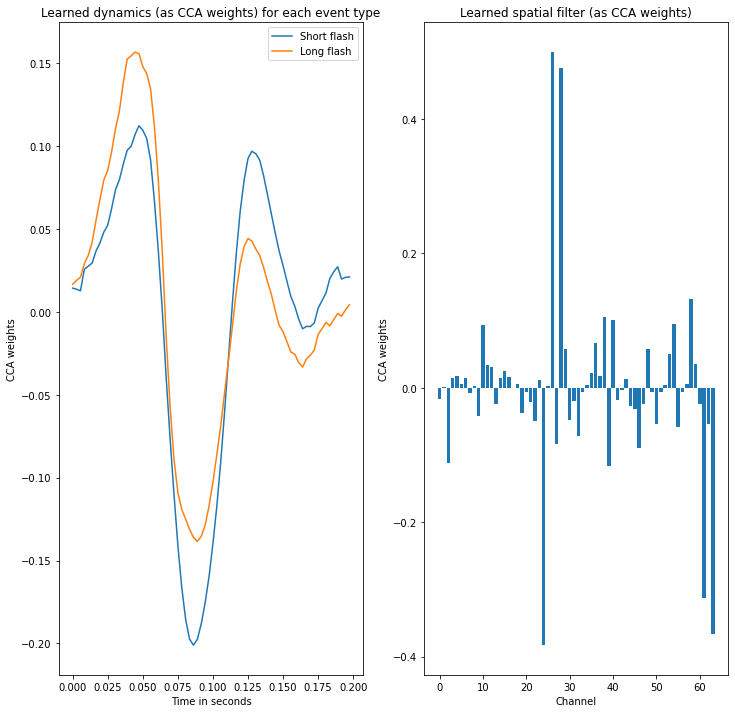

(1513, 144)


IndexError: tuple index out of range

In [106]:
ac = analyse_full('/Users/rorybeard/Comind/ThielenDataConverted/xsub-01/train/converted_360_2_48.mat', 360, 120, 0.2, '/Users/rorybeard/Comind/ThielenDataConverted/xsub-01/exposed_360_2_48.mat')

In [234]:
def analyse_debug(mat_file_path):
    """
    Import the train and test data and struct mats produced in Matlab and just test the CCA and prediction 
    """
    
    (data_train, cca_X_train, cca_Y_train, M_train, codes_train, labels_train,
    data_test, M_test, codes_test, labels_test, 
     codes_train_orig, codes_test_orign, templates) = load_processed(mat_file_path)
    
    print(cca_X_train.shape)
    print(cca_Y_train.shape)
    
    
    X_test = np.transpose(data_test, (2,1,0))
    
    
    cca = CCA(n_components=1)
    cca.fit(cca_X_train, cca_Y_train)
    
    templates_pred = np.zeros((data_test.shape[1], M_test.shape[2]))  # (n_test_trials, n_test_codes) = (108, 36)
    for i_code in range(M_test.shape[2]):
        templates_pred[:, i_code] = np.dot(M_test[:, :, i_code], cca.y_weights_[:, 0])
    
    
    
    acc = evaluate(cca, X_test, labels_test.flatten() - 1, M_test)
    
    print(acc)
    
    plot_cca_weights(cca, 1, 360)
    
    
    
    
    return acc
    
    
    
    

In [8]:
def flash_struct_mats(codes, f_eeg, f_pres, resp_len, eeg_trial_len):
    rate_ratio = f_eeg / f_pres
    n_resp_samp = int(f_eeg * resp_len)
    
    
    codes_up = np.repeat(codes, repeats=rate_ratio, axis=0)
    
    # loop the struct mats n_rep times where n_rep is the number of repetitions of the Gold codes in one trial
    n_reps = np.ceil(eeg_trial_len / struct_mats.shape[0])
    
    codes_rep = 
    
    evts_flash = stim2event(codes, axis=0, evtypes=['flash'])
    evts_up = np.repeat(evts_flash, repeats=rate_ratio, axis=0)
    evts_up = evts_up.astype(int)
    
    struct_mats = np.zeros((evts_up.shape[0], n_resp_samp, evts_up.shape[1]))
    for i_code in range(struct_mats.shape)
    
    
    
    struct_mats = np.repeat(struct_mats, repeats=n_reps, axis=0)
    
    # snip off the end if eeg_trial_len isn't exactly an integer multiple of the upsampled code len
    struct_mats = struct_mats[:eeg_trial_len, :, :]
    
    return evts_flash, struct_mats

SyntaxError: invalid syntax (<ipython-input-8-2a54b8de2746>, line 11)

In [273]:
def analyse_play(mat_file_path, f_eeg, f_pres, resp_len):
    
    X, Y, coords, codes, labels = load_thielen_train(mat_file_path)
    struct_mats = build_structure_mats_from_codes(codes, f_eeg, f_pres, resp_len, X.shape[1])
    
#     X_train = X[0, :, :]
#     Y_train = labels[0]
    
#     cca = train_single_pass(X_train, Y_train, struct_mats)
    
#     acc_0 = evaluate(cca, X[1:, :, :], labels[1:] - 1, struct_mats)
    
#     print(acc_0)
    
#     plot_cca_weights(cca, 2, f_eeg)


    print('struct_mats shape: ',struct_mats.shape)

    X_train = np.squeeze(X[:-1, :, :])
    Y_train = labels[:-1]
    
    cca = train_single_pass(X_train, Y_train, struct_mats)
    
    acc_0 = evaluate(cca, X[[-1], :, :], [labels[-1] - 1], struct_mats)
    
    plot_cca_weights(cca, 2, f_eeg)
    
    return acc_0
    
    

In [258]:
(data_train, cca_X_train, cca_Y_train, M_train, codes_train, labels_train,
    data_test, M_test, codes_test, labels_test, 
 codes_train_orig, codes_test_orig, templates) = load_processed('/Users/rorybeard/Comind/ThielenDataConverted/xsub-01/exposed_360_2_48.mat')

print(templates.shape)

X_train = np.transpose(data_train, (2, 1, 0))
X_train = np.reshape(X_train, (np.prod(X_train.shape[:-1]), -1))  # stack the trials
    


Y_train = np.squeeze(M_train[:, :, labels_train.flatten() - 1])  # -1 because we're going from 1-indexed to 0-indexed
    
Y_rows = Y_train.shape[0] * Y_train.shape[2]
Y_train = np.reshape(np.transpose(Y_train, (2, 0, 1)), (Y_rows, -1))

print(Y_train.shape)
print(cca_Y_train.shape)

# print(Y_train[:20, :] == cca_Y_train[:20, :])
print('codes_orig: ', codes_train_orig.shape)

flash_M_mine = flash_struct_mats(codes_train_orig, 360, 120, 0.2, 1513)[-1]
print('flash: ', flash_M_mine.shape)
Y_train_mine = np.squeeze(flash_M_mine[:, :, labels.flatten() - 1])

print(M_train.shape)
print(flash_M_mine.shape)

cca = CCA(n_components=1)
cca.fit(X_train, Y_train_mine)
    
    

(1513, 36)
(54468, 72)
(54468, 72)
codes_orig:  (126, 36)


UnboundLocalError: local variable 'struct_mats' referenced before assignment

(54468, 64)
(54468, 72)
doing this:  

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



n_test_trials:  108
top 2 preds:  13 0
top 2 preds:  19 9
top 2 preds:  21 13
top 2 preds:  24 16
top 2 preds:  29 7
top 2 preds:  4 33
top 2 preds:  14 23
top 2 preds:  1 6
top 2 preds:  28 33
top 2 preds:  35 30
top 2 preds:  3 16
top 2 preds:  34 31
top 2 preds:  20 1
top 2 preds:  16 31
top 2 preds:  17 24
top 2 preds:  25 29
top 2 preds:  26 27
top 2 preds:  16 30
top 2 preds:  11 8
top 2 preds:  23 35
top 2 preds:  9 34
top 2 preds:  18 3
top 2 preds:  32 28
top 2 preds:  27 31
top 2 preds:  6 7
top 2 preds:  9 22
top 2 preds:  31 34
top 2 preds:  2 15
top 2 preds:  15 10
top 2 preds:  0 2
top 2 preds:  5 1
top 2 preds:  12 6
top 2 preds:  33 10
top 2 preds:  10 25
top 2 preds:  7 18
top 2 preds:  8 23
top 2 preds:  27 31
top 2 preds:  29 7
top 2 preds:  14 23
top 2 preds:  35 21
top 2 preds:  25 29
top 2 preds:  11 25
top 2 preds:  22 31
top 2 preds:  18 3
top 2 preds:  30 1
top 2 preds:  0 21
top 2 preds:  33 28
top 2 preds:  27 34
top 2 preds:  10 25
top 2 preds:  12 2
top 2 p

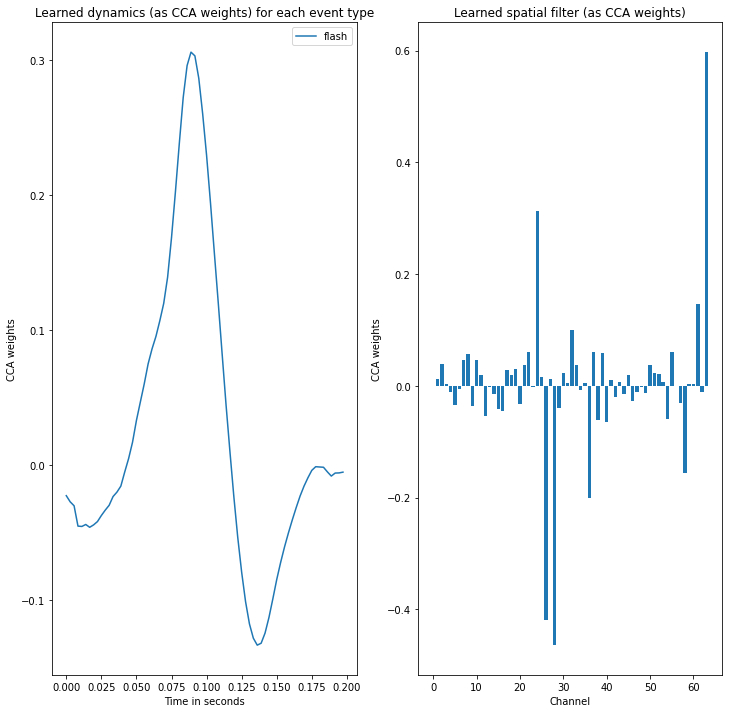

0.9537037037037037

In [235]:
analyse_debug('/Users/rorybeard/Comind/ThielenDataConverted/xsub-01/exposed_360_2_48.mat')

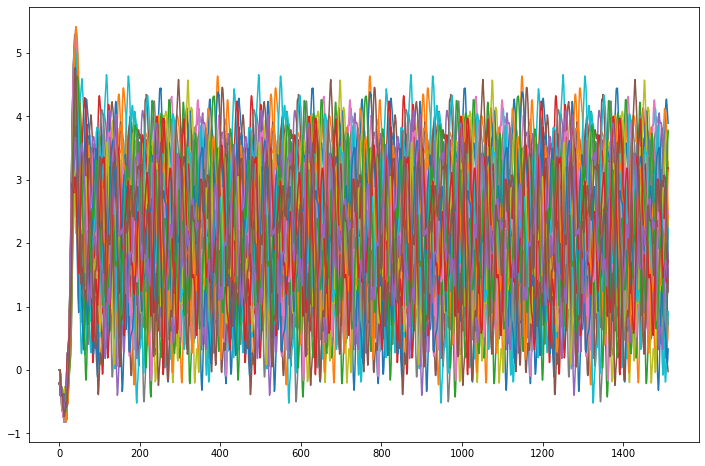

In [212]:
plt.figure()
plt.plot(templates)

In [151]:
a = np.random.rand(2,3,4)
print(a)
b = np.transpose(a, (2, 0, 1))
print(a.shape)
b = np.reshape(b,(8,3))
print(b)
desired = []
for i in range(a.shape[-1]):
    desired.append(a[:,:,i])
    
print(desired)
desired = np.vstack(desired)
print(desired)

oi = a[:,:,[1]]
print(oi.shape)


[[[0.42893027 0.45798336 0.37035647 0.29425275]
  [0.47812545 0.79129412 0.76607242 0.93509213]
  [0.41756095 0.00464521 0.06453919 0.46424947]]

 [[0.04611553 0.15300751 0.60096974 0.47739852]
  [0.64512389 0.49179274 0.48902298 0.93954866]
  [0.01175605 0.73425119 0.81250346 0.45517652]]]
(2, 3, 4)
[[0.42893027 0.47812545 0.41756095]
 [0.04611553 0.64512389 0.01175605]
 [0.45798336 0.79129412 0.00464521]
 [0.15300751 0.49179274 0.73425119]
 [0.37035647 0.76607242 0.06453919]
 [0.60096974 0.48902298 0.81250346]
 [0.29425275 0.93509213 0.46424947]
 [0.47739852 0.93954866 0.45517652]]
[array([[0.42893027, 0.47812545, 0.41756095],
       [0.04611553, 0.64512389, 0.01175605]]), array([[0.45798336, 0.79129412, 0.00464521],
       [0.15300751, 0.49179274, 0.73425119]]), array([[0.37035647, 0.76607242, 0.06453919],
       [0.60096974, 0.48902298, 0.81250346]]), array([[0.29425275, 0.93509213, 0.46424947],
       [0.47739852, 0.93954866, 0.45517652]])]
[[0.42893027 0.47812545 0.41756095]
 [0.

struct_mats shape:  (1513, 144, 36)
(1513, 144, 35)
(52955, 64)
(52955, 144)
n_test_trials:  1
top 2 preds:  5 0
here in plotting somehow
[-0.0122958  -0.00488278 -0.09815444 -0.01775246  0.01621974  0.00593699
  0.01302399  0.00298853 -0.00369376 -0.03865088  0.10734092  0.02884379
  0.03831568 -0.02685657  0.01516364  0.02596717  0.01413228 -0.0030421
  0.00487318 -0.03727413 -0.00393192 -0.02503805 -0.04099773  0.00808498
 -0.39331124  0.0113061   0.49340083 -0.08030944  0.47531824  0.06580248
 -0.0515608  -0.02338687 -0.06352212 -0.00734042  0.00428146  0.01952443
  0.04981497  0.03271618  0.11720863 -0.12160658  0.09537995 -0.02039782
 -0.00320003  0.01585619 -0.02048574 -0.00986935 -0.10877368 -0.01906582
  0.05568953 -0.00688641 -0.05994189 -0.0128894   0.00738036  0.05860299
  0.10021644 -0.06229623 -0.00649076  0.01337603  0.11267289  0.0420931
 -0.0291591  -0.3162873  -0.05508024 -0.35814811]


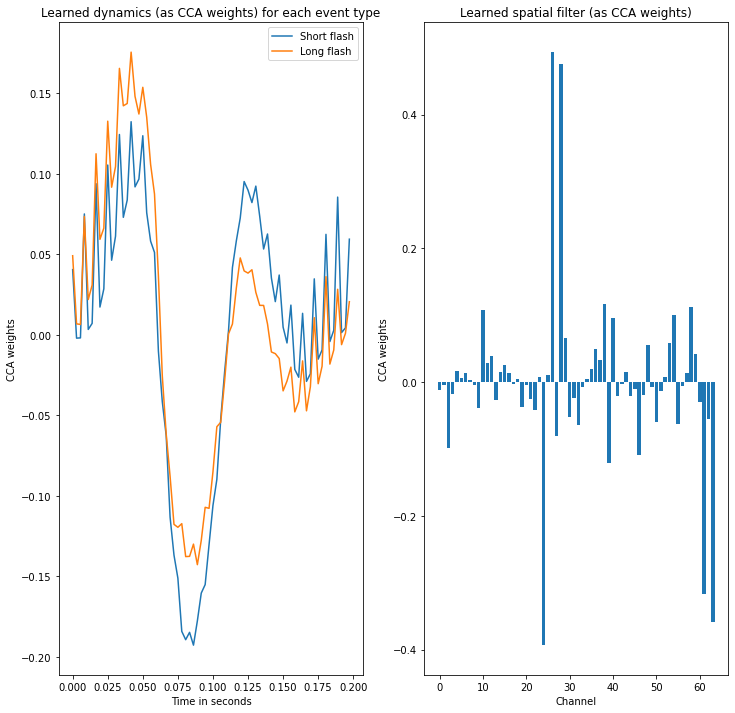

In [274]:
ac0 = analyse_play('/Users/rorybeard/Comind/ThielenDataConverted/xsub-01/train/converted_360_2_48.mat', 360, 120, 0.2)

In [275]:
ac0

1.0

In [198]:
oi, oi_up = flash_struct_mats(codes, 360, 120, 0.2)

In [201]:
print(oi[:,:,0].astype(int))


[[1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1]
 [0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 0]
 [1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1]
 [0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0]
 [1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 1]
 [0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1]
 [1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0]
 [1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1]
 [0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0]
 [1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1]
 [0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0]
 [1 1 0 1 0 0 1 0 0 0 0 0

In [199]:
print(oi_up[:,:,0])

[[1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1]
 [1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1]
 [1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1]
 [0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 0]
 [0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 0]
 [0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 0]
 [1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1]
 [1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1]
 [1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1]
 [0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 0 1

In [79]:
X, Y, coords, codes, labels = load_thielen_train('/Users/rorybeard/Comind/ThielenDataConverted/xsub-01/train/converted_360_2_48.mat')

(64, 1513, 36)
(36, 1513, 64)


In [49]:
U = np.random.random_sample(500).reshape(100,5)
V = np.random.random_sample(500).reshape(100,5)

cca = CCA(n_components=1)
cca.fit(U, V)

CCA(n_components=1)

In [50]:
score = np.diag(np.corrcoef(cca.x_scores_, cca.y_scores_, rowvar=False)[:1, 1:])

U_c, V_c = cca.transform(U, V)
result = np.corrcoef(U_c.T, V_c.T).diagonal(offset=1)

[0.43855949]
[0.43855949]
[[ 0.08790773 -0.00681694 -0.04381592 -0.06044445  0.0263928 ]
 [-0.11558401  0.00896314  0.05761062  0.07947437 -0.03470213]
 [ 0.15739329 -0.0122053  -0.07844965 -0.10822199  0.04725466]
 [ 0.00757743 -0.0005876  -0.00377682 -0.00521016  0.00227499]
 [ 0.05359799 -0.00415634 -0.02671489 -0.03685342  0.01609189]]
[[ 0.39797941]
 [-0.52327654]
 [ 0.71255719]
 [ 0.03430483]
 [ 0.24265096]]
[[ 0.62803339]
 [-0.03284929]
 [-0.4770434 ]
 [-0.56266106]
 [ 0.24563614]]
[ 0.62803339 -0.03284929 -0.4770434  -0.56266106  0.24563614]


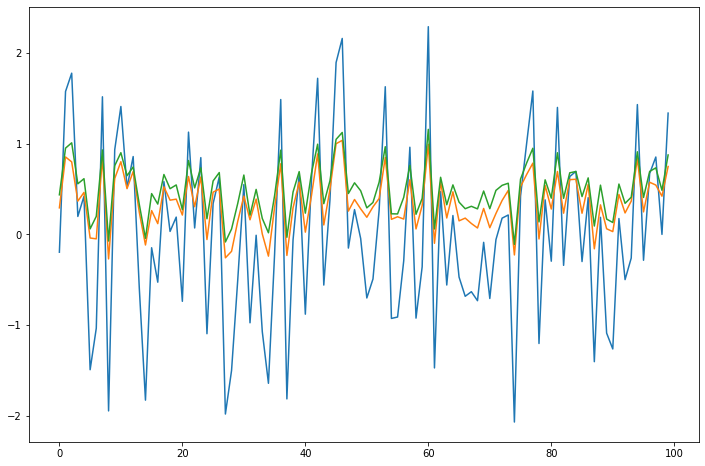

In [128]:
print(score)
print(result)
print(cca.coef_)
print(cca.x_weights_)
print(cca.y_weights_)
U_c == np.dot(V, cca.x_weights_)
plt.figure()
plt.plot(U_c)
plt.plot(np.dot(U, cca.x_loadings_))
plt.plot(np.dot(U, cca.x_weights_))
print(cca.y_weights_[:,0])

In [164]:
print(labels[0:2].flatten().shape)
print(labels[0].flatten().shape)
print(X[:,:,labels[0:2].flatten()].shape)
print(X[:,:,labels[0].flatten()].shape)

(2,)
(1,)
(36, 1513, 2)
(36, 1513, 1)


In [185]:
sm = build_structure_mats_from_codes(codes, 360, 120, 0.25)

In [186]:
sm.shape

(378, 180, 36)

In [71]:

stims_ = stim2event(Y, axis=1, evtypes=['long', 'short'])
print(stims_.shape)


(36, 1513, 37, 2)


In [72]:
stims_[0, :, 0, :]

array([[False, False],
       [False, False],
       [False, False],
       ...,
       [False, False],
       [False,  True],
       [False, False]])

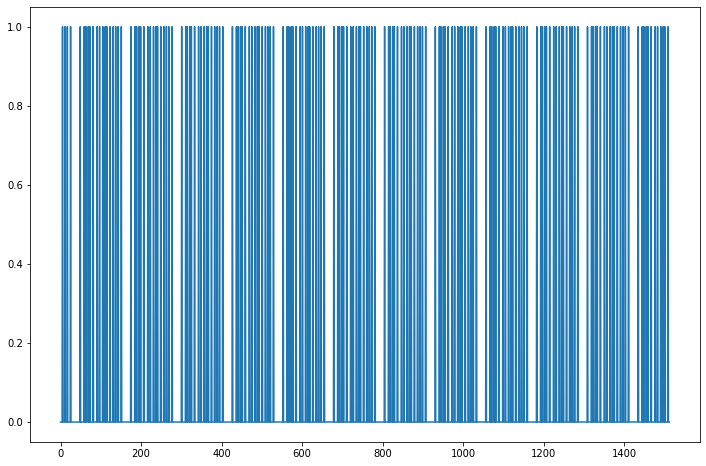

In [73]:
plt.plot(stims_[0, :, 0, 0])

In [44]:
import matplotlib.pyplot as plt

In [45]:
do = stims[0,:,1,0].astype(int)

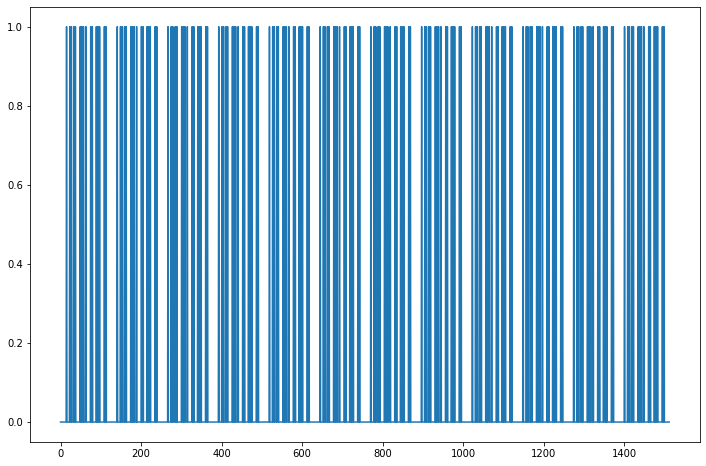

In [46]:
plt.plot(do)

In [19]:
X.shape

(36, 1513, 64)

In [35]:
c = codes[:,15].astype(int)

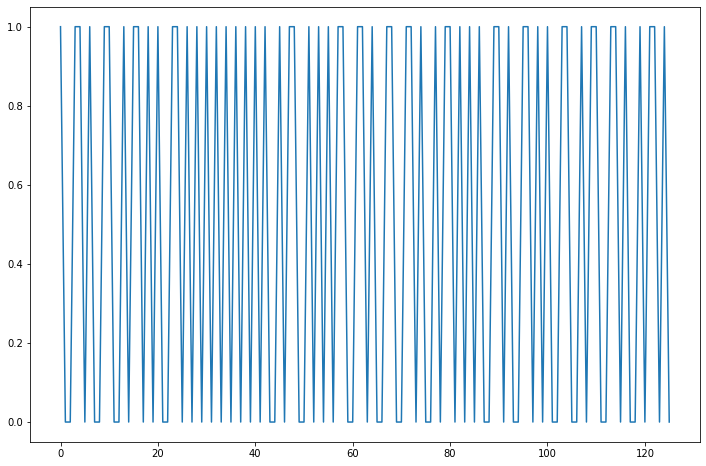

In [36]:
plt.plot(c)

In [55]:
codes.shape

(126, 36)

In [56]:
looped = np.mod(np.arange(0, X.shape[1]), codes.shape[0])

In [57]:
looped.shape

(1513,)

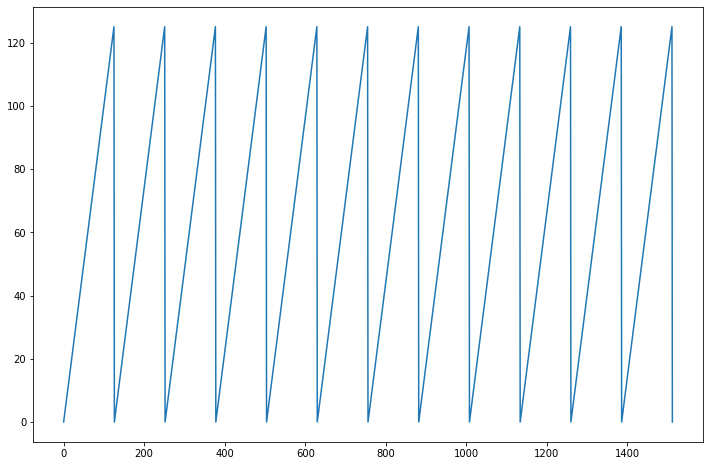

In [58]:
plt.plot(looped)

In [81]:
stims_pre_up = stim2event(codes, axis=0, evtypes=['short', 'long'])

In [82]:
stims_pre_up.shape

(126, 36, 2)

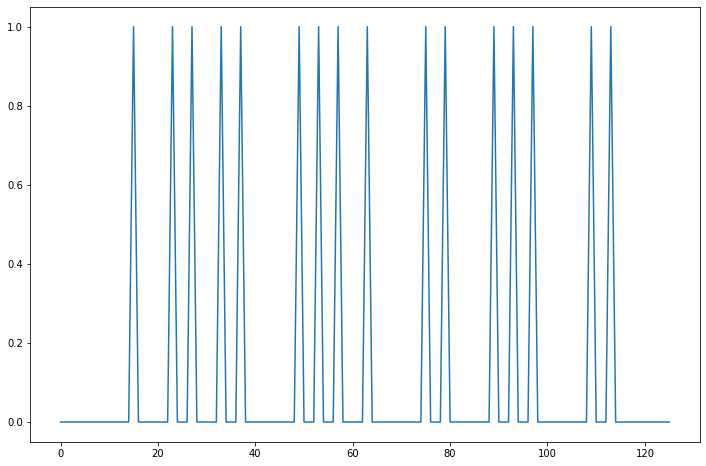

In [83]:
plt.plot(stims_pre_up[:, 0, 1])

In [84]:
stims_then_up = np.repeat(stims_pre_up, repeats=3, axis=0)

In [85]:
stims_then_up.shape

(378, 36, 2)

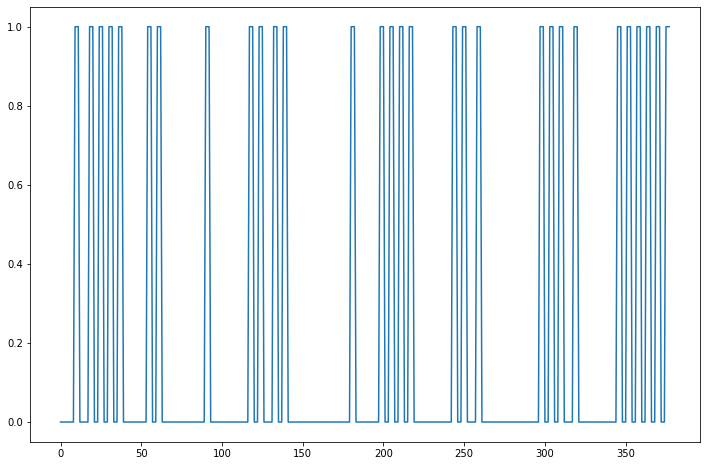

In [86]:
plt.plot(stims_then_up[:,0,0])

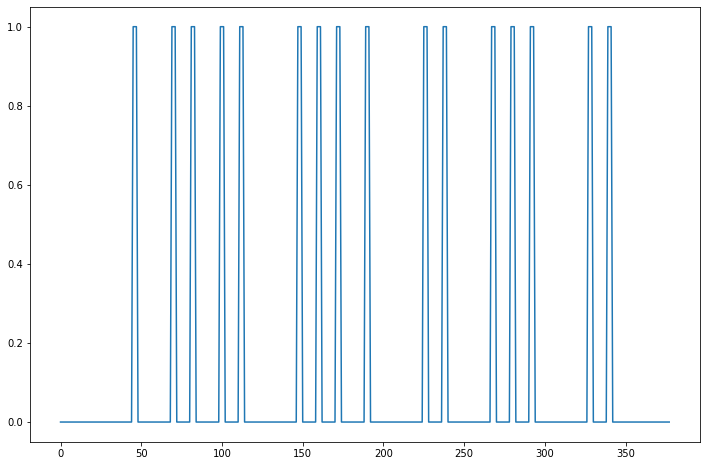

In [87]:
plt.plot(stims_then_up[:,0,1])

In [88]:
import scipy.linalg as linalg

In [98]:
a = stims_then_up[:21, 0, 0].astype(int)
print(a.shape)
# tp = linalg.toeplitz(a)
tp = linalg.toeplitz(a, np.zeros(21,))
print(a)
print(tp)

(21,)
[0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 

In [99]:
aa = stims_then_up[:21, :2, 0].astype(int)
print(aa.shape)
tpp = linalg.toeplitz(aa)

(21, 2)


In [100]:
tpp.shape

(42, 42)

In [103]:
print(tpp[:,0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1
 0 1 0 1 0]


In [106]:
aa[:,0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [107]:
tpp[:21, 0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1])

In [108]:
aa[:, 1]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [109]:
tpp[21:, 0]

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0])

In [130]:
aa = stims_then_up[:21, :2, 0].astype(int)
aaa = aa.transpose()
print(aaa.shape)
aaa = np.reshape(aaa, [aa.shape[0]*aa.shape[1], -1])
print(aaa.shape)

(2, 21)
(42, 1)


In [131]:
aa.shape

(21, 2)

In [132]:
aaa = aaa.flatten()

In [133]:
aaa

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [134]:
aa

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

In [129]:
aaa

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0])

In [137]:
tpp = linalg.toeplitz(aaa, np.zeros(42))

In [142]:
tpp = tpp.astype(int)

In [144]:
tpp = tpp.reshape(2, 21, -1)

In [146]:
tpp[0, :, :]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],